<a href="https://www.kaggle.com/code/oxyroid/analysis-and-prediction-of-istanbul-housing-prices?scriptVersionId=216503955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ipywidgets import Dropdown, IntSlider, FloatSlider, interact 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/ev-fiyatlar-2023/istanbul_satilik_evler_2023.csv


* [Prepare Data](#chapter1)
    * [Import](#section_1_1)
    * [Explore](#section_1_2)
    * [Split](#section_1_3)
* [Build Model](#Section_1_2)
    * [BaseModel](#section_2_1)
    * [Iterate](#section_2_2)
    * [Evaluate](#section_2_3)
* [Communicate Results](#chapter2)
    

# Prepare Data

# Import

In [2]:
def wrangle(filename):
    df = pd.read_csv(filename)
    
    # Convert to numeric (coerce errors to handle invalid data)
    df["Price"] = pd.to_numeric(df["Price"], errors='coerce')
    
    # Drop rows with NaN values in "Price" after conversion
    df = df.dropna(subset=["Price"])
    
    # split room columns to separate the bedrooms from the living rooms
    df["Room"] = df["Room"].str.split("+",expand = True)[0]
    
    # Convert the price from local currency to USD
    df["Price (USD)"] = (df["Price"] / 29).round(2)  # Assuming 1 USD = 29 local currency
    
    # drop colunms
    df.drop(columns = "Price", inplace = True)
    
    # change numerical columns from object to float
    df["Area"] = df["Area"].replace(r'[^\d.]', '', regex = True).astype(float)
    df["Age"] = df["Age"].replace(r'[^\d.]', '', regex = True).astype(float)
    df["Floor"] = df["Floor"].replace(r'[^\d.]', '', regex = True).astype(float)
    df["Room"] = df["Room"].replace(r'[^\d.]', '', regex = True).astype(float)
    
    
    # drop outliers
    low, high = df["Area"].quantile([0.1,0.9])
    mask_area = df["Area"].between(low, high)
    low, high = df["Price (USD)"].quantile([0.1,0.9])
    mask_price = df["Price (USD)"].between(low, high)
    low, high = df["Age"].quantile([0.1,0.9])
    mask_age = df["Age"].between(low, high)
    df = df[mask_area & mask_price & mask_age]
    
    # return dataframe
    return df

The wrangle function above takes a filepath as an argument, cleans the data and returns a dataframe. 

In [3]:
# use the wrangle function to create a DataFrame from the CSV file
df = wrangle("/kaggle/input/ev-fiyatlar-2023/istanbul_satilik_evler_2023.csv")
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 58107 entries, 4 to 92691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Room         58107 non-null  float64
 1   Area         58107 non-null  float64
 2   Age          58107 non-null  float64
 3   Location     58107 non-null  object 
 4   Floor        58107 non-null  float64
 5   Price (USD)  58107 non-null  float64
dtypes: float64(5), object(1)
memory usage: 3.1+ MB


,Room,Area,Age,Location,Floor,Price (USD)
92686,3.0,90.0,0.0,Şişli,4.0,232758.62
92687,2.0,115.0,31.0,Şişli,3.0,224137.93
92688,3.0,90.0,30.0,Şişli,1.0,75862.07
92689,3.0,130.0,25.0,Şişli,3.0,100000.00
92691,3.0,90.0,0.0,Şişli,4.0,232758.62


In [4]:
# looking for null values
df.nunique().isnull()

Room           False
Area           False
Age            False
Location       False
Floor          False
Price (USD)    False
dtype: bool

The data contains no null values.

# Explore

Lets take a look at the distribution of Price and Area

In [5]:
# calculate the distribution of Area & Price
df[["Area","Price (USD)"]].describe()

,Area,Price (USD)
count,58107.000000,58107.000000
mean,126.890254,170383.571878
std,30.646687,97558.521420
min,80.000000,60241.380000
25%,100.000000,96551.720000
50%,125.000000,137241.380000
75%,146.000000,224137.930000
max,202.000000,481034.480000


Let's use boxplot to check for outliers

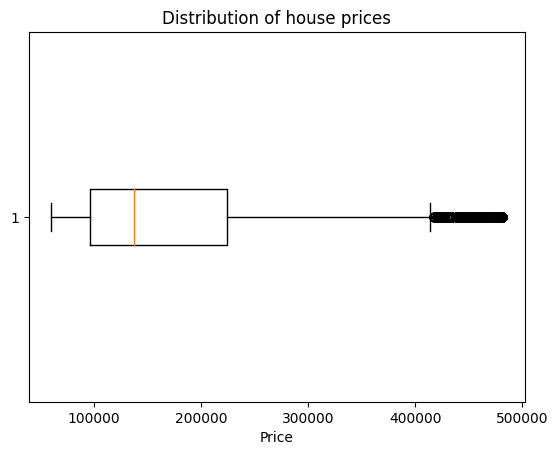

In [6]:
plt.boxplot(df["Price (USD)"], vert = False)
plt.xlabel("Price")
plt.title("Distribution of house prices");

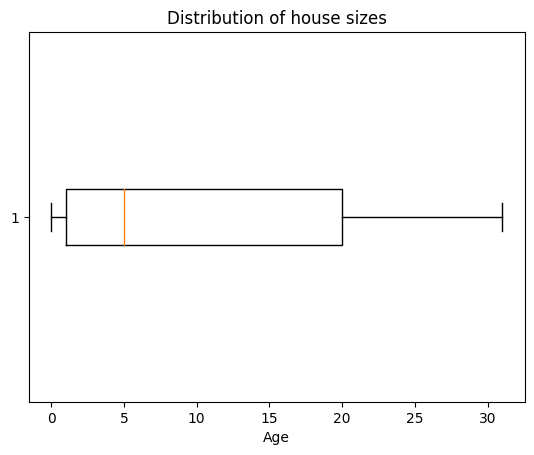

In [7]:
plt.boxplot(df["Age"], vert = False)
plt.xlabel("Age")
plt.title("Distribution of house sizes");

The small circles in the boxplot indicate that there outliers, so we'll use the wrangle function to remove the outliers.

<Axes: >

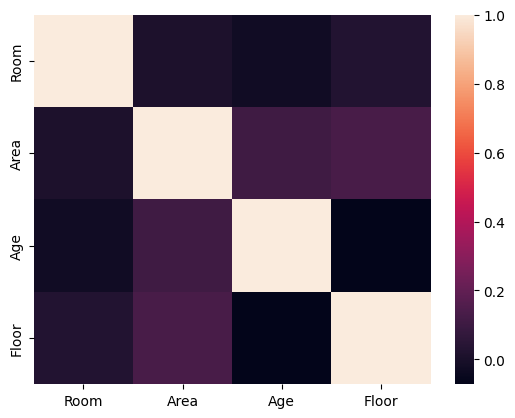

In [8]:
# plot correlation heatmap
corr = df.select_dtypes("number").drop(columns = "Price (USD)").corr()
sns.heatmap(corr)

The map indicates the features in tthe features matrix are not highly correlated with each other.

# Split

In [9]:
# split data to feature matrix and target vector
target = "Price (USD)"
y = df[target]
X = df.drop(columns = target)



In [10]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.2, random_state = 42)

# Build Model

# Baseline

In [11]:
# create baseline model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 170543.1
Baseline MAE: 78026.87


# Iterate

In [12]:
# build and fit model
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Location'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

# Evaluate

In [13]:
# make predictions using predict method
y_pred_train = model.predict(X_train)
 
print("Training MAE:", round(mean_absolute_error(y_pred_train,y_train), 2))

Training MAE: 63575.46


In [14]:
y_pred_test = model.predict(X_test)
 
print("Training MAE:", round(mean_absolute_error(y_pred_test,y_test), 2))

Training MAE: 63997.58


# Communicate Results

Below is a make_prediction that takes 5 arguments and returns predictions

In [15]:
def make_prediction(Room, Area, Age, Location, Floor):
    data = {
    "Room": Room,
    "Area": Area,   
    "Age": Age,
    "Location": Location,
    "Floor": Floor
    }
    df  = pd.DataFrame(data, index = [0])  
    prediction = model.predict(df).round(2)[0]
    return f'Predicted Istanbul Apartment Price:${prediction}.'

In [16]:
make_prediction(3.0, 110.0, 31.0, "Adalar", 2.0)

'Predicted Istanbul Apartment Price:$139117.42.'

In [17]:
# Interact Widget
interact(
    make_prediction,
    Area = IntSlider(
        min = X_test["Area"].min(),
        max  = X_test["Area"].max(),
        value = X_test["Area"].mean()   
    ),
    Floor = FloatSlider(
        min = X_test["Floor"].min(),
        max = X_test["Floor"].max(),
        step = 1,
        value = X_test["Floor"].mean()
    ),
    
    Age = FloatSlider(
        min = X_test["Age"].min(),
        max = X_test["Age"].max(),
        step = 1,
        value = X_test["Age"].mean()
    ),
    Room = FloatSlider(
        min = X_test["Room"].min(),
        max = X_test["Room"].max(),
        step = 1,
        value = X_test["Room"].mean()
    ),
    Location = Dropdown(options = sorted(X_test["Location"].unique()))

);

interactive(children=(FloatSlider(value=3.375580795043882, description='Room', max=6.0, min=2.0, step=1.0), In…

The interactive widget is created for use by stakeholders to deploy the model and make predictions.